In [1]:
import torch
from torch import FloatTensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from tools import *
plt.rcParams['figure.figsize'] = (10,7)
%matplotlib inline

In [2]:
mean = 0.1307
stddev = 0.3081

def imshow(img):
    img = img*stddev + mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean,), (stddev,))])

batch_size = 100
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True,
                                      transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [3]:
class DiscriminatorNet(torch.nn.Module):                                                                
    def __init__(self, n_in, n_hidden0, n_hidden1, n_hidden2, n_out):                          
        super(DiscriminatorNet, self).__init__()                                                        
        self.hidden0 = torch.nn.Linear(n_in, n_hidden0)                                        
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)                                         
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out     = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.Dropout(0.3)(x)
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = torch.nn.Dropout(0.3)(x)
        x = self.out(x)
        return x
    
class GeneratorNet(torch.nn.Module):
    def __init__(self, n_in, n_hidden0, n_hidden1, n_hidden2, n_out):
        super(GeneratorNet, self).__init__()
        assert(n_in == n_out)
        self.hidden0 = torch.nn.Linear(n_in, n_hidden0)                                        
        self.hidden1 = torch.nn.Linear(n_hidden0, n_hidden1)                                         
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.out     = torch.nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.2)(self.hidden0(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden1(x))
        x = torch.nn.LeakyReLU(0.2)(self.hidden2(x))
        x = self.out(x)
        return x

## Train the GAN

$$ \max_G \min_D \| D(G(x)) - y \|_2^2 $$

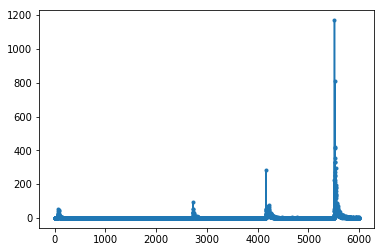

In [4]:
n = 784
D = DiscriminatorNet(n, 256, 128, 64, 2)     
G = GeneratorNet(n, 256, 64, 256, n)
D_opt = torch.optim.Adam(D.parameters())
G_opt = torch.optim.Adam(G.parameters())
#criterion = torch.nn.MSELoss()
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
D_losses_raw = []
D_losses_clean = []

for epoch in range(epochs): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        X, y = Variable(inputs), Variable(labels)
        y = (y == 5).long()
        X = X.view(-1,784)
    
        #y_hat = D(xtr)
        #D.zero_grad()
        #D_loss_raw = loss(y_hat, ytr)
        #D_losses_raw.append(D_loss_raw)
        X_tild = G(X)
        y_tild = D(X_tild)
        
        D.zero_grad()
        D_loss = criterion(y_tild, y)
        D_losses_clean.append(D_loss.data[0])
        D_loss.backward(retain_graph = True)
        D_opt.step()
        
        G.zero_grad()
        G_loss = -criterion(y_tild, y)
        G_loss.backward()
        G_opt.step()
        
plt.plot(D_losses_clean,'.-')

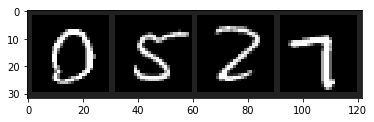

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

X = Variable(images)
X = X.view(-1,784)
Xhat = G(X)
Xhat = Xhat.view(-1,1,28,28)
#print(cleaned.data.size())

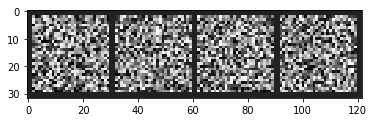

In [32]:
imshow(torchvision.utils.make_grid(Xhat.data))